In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import time
import torch
import skimage
import numpy as np
import ase.io as aio
from ase import Atoms
from toolz.curried import pipe, curry

In [3]:
import plot
import atommks.helpers as utils

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

In [8]:
from scipy import fftpack as sp_ft
def _radial_profile(autocorr, r_max, nbins=100):
    r"""
    Helper functions to calculate the radial profile of the autocorrelation
    Masks the image in radial segments from the center and averages the values
    The distance values are normalized and 100 bins are used as default.
    Parameters
    ----------
    autocorr : ND-array
        The image of autocorrelation produced by FFT
    r_max : int or float
        The maximum radius in pixels to sum the image over
    Returns
    -------
    result : named_tuple
        A named tupling containing an array of ``bins`` of radial position
        and an array of ``counts`` in each bin.
    """
    if len(autocorr.shape) == 2:
        adj = np.reshape(autocorr.shape, [2, 1, 1])
        inds = np.indices(autocorr.shape) - adj / 2
        dt = np.sqrt(inds[0]**2 + inds[1]**2)
    elif len(autocorr.shape) == 3:
        adj = np.reshape(autocorr.shape, [3, 1, 1, 1])
        inds = np.indices(autocorr.shape) - adj / 2
        dt = np.sqrt(inds[0]**2 + inds[1]**2 + inds[2]**2)
    else:
        raise Exception('Image dimensions must be 2 or 3')
    bin_size = np.int(np.ceil(r_max / nbins))
    bins = np.arange(bin_size, r_max, step=bin_size)
    radial_sum = np.zeros_like(bins)
    for i, r in enumerate(bins):
        # Generate Radial Mask from dt using bins
        mask = (dt <= r) * (dt > (r - bin_size))
        radial_sum[i] = np.sum(autocorr[mask]) / np.sum(mask)
    # Return normalized bin and radially summed autoc
    norm_autoc_radial = radial_sum / np.max(autocorr)
#     tpcf = namedtuple('two_point_correlation_function',
#                       ('distance', 'probability'))
    return bins, norm_autoc_radial


def two_point_correlation_fft(im):
    r"""
    Calculates the two-point correlation function using fourier transforms
    Parameters
    ----------
    im : ND-array
        The image of the void space on which the 2-point correlation is desired
    Returns
    -------
    result : named_tuple
        A tuple containing the x and y data for plotting the two-point
        correlation function, using the *args feature of matplotlib's plot
        function.  The x array is the distances between points and the y array
        is corresponding probabilities that points of a given distance both
        lie in the void space.
    Notes
    -----
    The fourier transform approach utilizes the fact that the autocorrelation
    function is the inverse FT of the power spectrum density.
    For background read the Scipy fftpack docs and for a good explanation see:
    http://www.ucl.ac.uk/~ucapikr/projects/KamilaSuankulova_BSc_Project.pdf
    """
    # Calculate half lengths of the image
    hls = (np.ceil(np.shape(im)) / 2).astype(int)
    # Fourier Transform and shift image
    F = sp_ft.ifftshift(sp_ft.fftn(sp_ft.fftshift(im)))
    # Compute Power Spectrum
    P = np.absolute(F**2)
    # Auto-correlation is inverse of Power Spectrum
    autoc = np.absolute(sp_ft.ifftshift(sp_ft.ifftn(sp_ft.fftshift(P))))
    tpcf = _radial_profile(autoc, r_max=np.min(hls))
    return tpcf

In [12]:
def grid_maker(fname, len_pixel=1, r_atom=5.0, verbose=True):
    import atommks.grid_generator as gen
    
    atoms = pipe(fname, 
                 lambda f: utils.load_file(f), 
                 lambda a: get_atoms(a))
    
    idx = np.where(atoms.get_tags() != 1)[0]    
    if len(idx) == 0:
        np.random.seed(81396)
        idx = np.random.randint(low=0, high=len(atoms), size=2000)
    
    coords_all = atoms.get_positions()
    coords_sub = coords_all[idx]
    
    if verbose:
        print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))
    
    atoms_1 = Atoms(positions=coords_sub,  cell=atoms.get_cell(), pbc=atoms.get_pbc())
    radii = {}
    for idx in sorted(np.unique(atoms_1.get_chemical_symbols())):
        radii[idx] = r_atom    
    return gen.grid_maker(atoms_1, len_pixel=len_pixel, atomic_radii=radii, full=True, fft=True)[1][0]

# @curry
# def prop_maker(run, len_pixel=1, r_atom=5.0, f_tag=""):
#     import porespy as ps
    
#     fname = "data/structs/dump.arc.{}_atom.pkl".format(run)
    
#     im = grid_maker(fname, len_pixel=len_pixel, r_atom=r_atom, verbose=False)
#     dct = {}
#     dct["tpt"] = ps.metrics.two_point_correlation_fft(im).probability
    
#     fout = f_tag + "dump.arc.{}_pores.pkl".format(run)
#     print("{}, porosity: {}\n".format(run, ps.metrics.porosity(im)))
#     utils.save_file(fname=fout, obj=dct)
    
@curry
def prop_maker(run, len_pixel=1, r_atom=5.0, f_tag=""):
    
    fname = "data/structs/dump.arc.{}_atom.pkl".format(run)
    
    im = grid_maker(fname, len_pixel=len_pixel, r_atom=r_atom, verbose=False)
    dct = {}
    bins, dct["tpt"] = ps.metrics.two_point_correlation_fft(im)
    
    fout = f_tag + "dump.arc.{}_pores.pkl".format(run)
    print("{}, porosity: {}\n".format(run, ps.metrics.porosity(im)))
    utils.save_file(fname=fout, obj=dct)
    
    
@curry
def cld_maker(run, len_pixel=1, r_atom=5.0, f_tag=""):
    import porespy as ps
    
    fname = "data/structs/dump.arc.{}_atom.pkl".format(run)
    
    im = grid_maker(fname, len_pixel=len_pixel, r_atom=r_atom, verbose=False)
    dct = {}

    chords_x = ps.filters.apply_chords(im, axis=0, spacing=1, trim_edges=True)
    chords_y = ps.filters.apply_chords(im, axis=1, spacing=1, trim_edges=True)

    cld_x = ps.metrics.chord_length_distribution(chords_x,bins=np.arange(300),log=False)
    cld_y = ps.metrics.chord_length_distribution(chords_y,bins=np.arange(300),log=False)
    
    dct["cld_x_pdf"] = cld_x.pdf
    dct["cld_x_cdf"] = cld_x.cdf
    dct["cld_x_bc"] = cld_x.bin_centers
    
    dct["cld_y_pdf"] = cld_y.pdf
    dct["cld_y_cdf"] = cld_y.cdf
    dct["cld_y_bc"] = cld_y.bin_centers
    
    fout = f_tag + "dump.arc.{}_clds.pkl".format(run)
    print("{}, porosity: {}\n".format(run, ps.metrics.porosity(im)))
    utils.save_file(fname=fout, obj=dct)

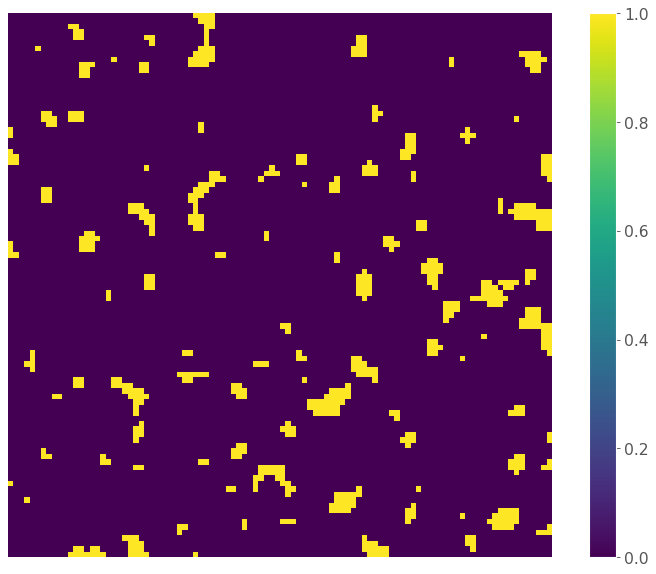

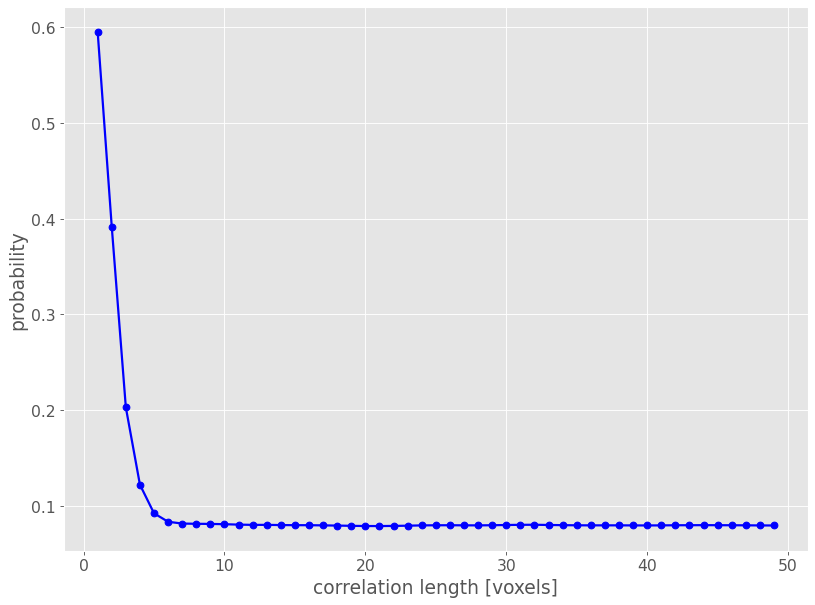

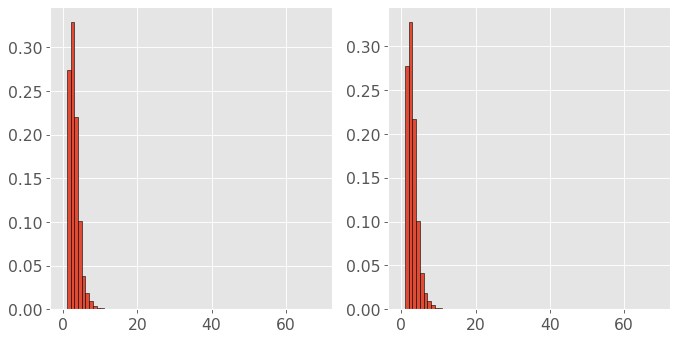

CPU times: user 12.1 s, sys: 490 ms, total: 12.5 s
Wall time: 2 s


In [10]:
%%time
import porespy as ps

im = ps.generators.blobs(shape=[100, 100, 100], porosity=0.08, blobiness=2)
plot.draw_2d(im[:,:,50])

bins, sig = two_point_correlation_fft(im)
fig = plt.plot(bins, sig, 'bo-')
plt.ylabel('probability')
plt.xlabel('correlation length [voxels]')
plt.show()

chords_x = ps.filters.apply_chords(im, axis=0, spacing=1, trim_edges=True)
chords_y = ps.filters.apply_chords(im, axis=1, spacing=1, trim_edges=True)

cld_x = ps.metrics.chord_length_distribution(chords_x,bins=np.arange(70),log=False)
cld_y = ps.metrics.chord_length_distribution(chords_y,bins=np.arange(70),log=False)

fig, (ax0,ax1) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
ax0.bar(cld_x.bin_centers,cld_x.relfreq,width=cld_x.bin_widths,edgecolor='k')
ax1.bar(cld_y.bin_centers,cld_y.relfreq,width=cld_y.bin_widths,edgecolor='k')
plt.show()

data/structs/dump.arc.500_atom.pkl
total atoms: 4000000, disturbed atoms: 87589


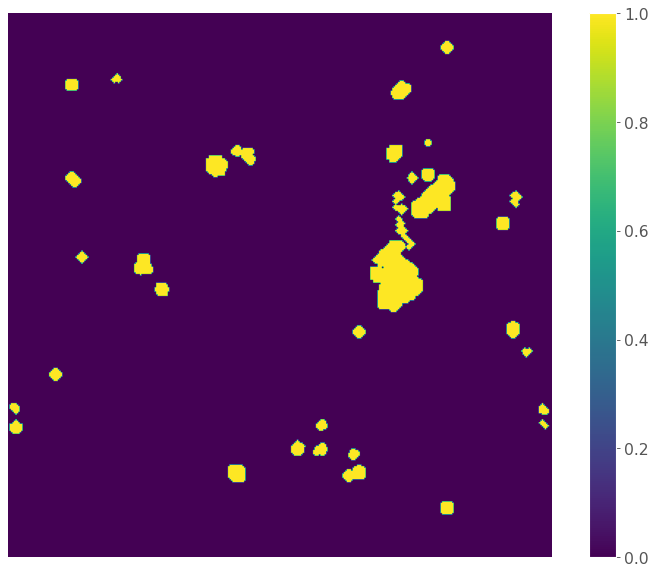

porosity: 0.04450289652496706


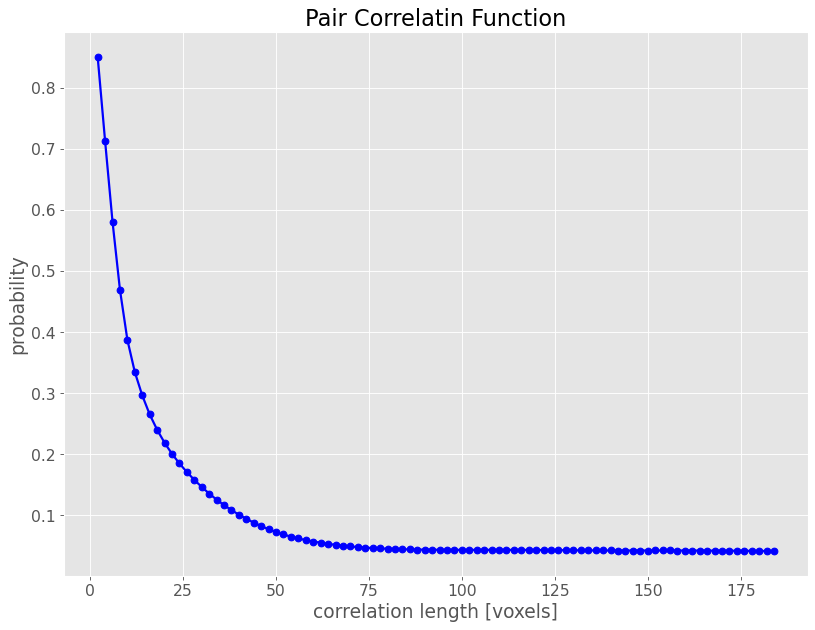

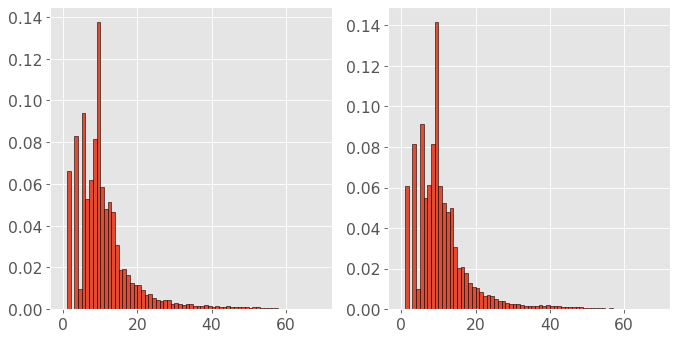

CPU times: user 1min 40s, sys: 9.65 s, total: 1min 49s
Wall time: 51.3 s


In [14]:
%%time
len_pixel = 1
r_atom = 3.0

run = runs[1]
fname = "data/structs/dump.arc.{}_atom.pkl".format(run)
print(fname)
S_cas = grid_maker(fname, len_pixel=len_pixel, r_atom=r_atom)
idx = S_cas.shape[-1]//2
plot.draw_2d(S_cas[:,:,idx])

print("porosity: {}".format(ps.metrics.porosity(S_cas)))

im = S_cas.copy()
bins, sig = two_point_correlation_fft(S_cas)
fig = plt.plot(bins, sig, 'bo-')
plt.ylabel('probability')
plt.xlabel('correlation length [voxels]')
plt.title("Pair Correlatin Function")

chords_x = ps.filters.apply_chords(im, axis=0, spacing=1, trim_edges=True)
chords_y = ps.filters.apply_chords(im, axis=1, spacing=1, trim_edges=True)

cld_x = ps.metrics.chord_length_distribution(chords_x,bins=np.arange(70),log=False)
cld_y = ps.metrics.chord_length_distribution(chords_y,bins=np.arange(70),log=False)

fig, (ax0,ax1) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
ax0.bar(cld_x.bin_centers,cld_x.relfreq,width=cld_x.bin_widths,edgecolor='k')
ax1.bar(cld_y.bin_centers,cld_y.relfreq,width=cld_y.bin_widths,edgecolor='k')
plt.show()

# Following loop generates features for all structures

In [43]:
import os
import multiprocessing as mp
n_proc = 14

folder_out = "data/porespy_cld_3/"
if not os.path.exists(folder_out):
    os.mkdir(folder_out)
    
with mp.Pool(n_proc) as p:
#     p.map(cld_maker(r_atom=3., len_pixel=1, f_tag=folder_out), runs[1:])
#     prop_maker(r_atom=5.0, len_pixel=1, f_tag="data/porespy/")(runs[1])

500, porosity: 0.04450289652496706

1500, porosity: 0.09003107834864991

2500, porosity: 0.10233508942195046

3500, porosity: 0.11279516926049134

4500, porosity: 0.12768865432597018

6500, porosity: 0.1381124273621614

10500, porosity: 0.14133809287965446

5500, porosity: 0.1404366893671652

12500, porosity: 0.14577441596719118

11500, porosity: 0.1410809099048658

9500, porosity: 0.1409051136995298

7500, porosity: 0.13787987974732738

8500, porosity: 0.14615526531567893

1000, porosity: 0.06945955405572733

13500, porosity: 0.15230891582072045

2000, porosity: 0.09761632134504522

3000, porosity: 0.11134714666818213

4000, porosity: 0.11324287482430906

5000, porosity: 0.12867156210565434

7000, porosity: 0.1391213608917499

6000, porosity: 0.14354009848386592

8000, porosity: 0.1486169017643089

11000, porosity: 0.14095585314121695

10000, porosity: 0.13796159942704966

14500, porosity: 0.14899786861053887

12000, porosity: 0.1443963828633381

13000, porosity: 0.14545762247117688

